# Intro:
In this notebook, we combine all journals into the same dataframe, then search the dataframe for terms relevant to iron-sulfur clusters to trace interest in the field since their discovery.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/american-chemical-society-journals/chem_revs.json
/kaggle/input/american-chemical-society-journals/jacs.json
/kaggle/input/american-chemical-society-journals/organometallics.json
/kaggle/input/american-chemical-society-journals/inorg_chem.json
/kaggle/input/american-chemical-society-journals/biochem.json


In [2]:
df_bc = pd.read_json('/kaggle/input/american-chemical-society-journals/biochem.json')
df_jacs = pd.read_json('/kaggle/input/american-chemical-society-journals/jacs.json')
df_ic = pd.read_json('/kaggle/input/american-chemical-society-journals/inorg_chem.json')
df_om = pd.read_json('/kaggle/input/american-chemical-society-journals/organometallics.json')
df_cr = pd.read_json('/kaggle/input/american-chemical-society-journals/chem_revs.json')

df = pd.concat([df_bc, df_jacs, df_ic, df_om, df_cr])
print(df.describe())
print(df.columns)

                year         volume          issue
count  365299.000000  365299.000000  365299.000000
mean     1986.347173      70.012910      16.009535
std        25.667462      41.690706      12.361098
min      1879.000000       1.000000       1.000000
25%      1972.000000      33.000000       6.000000
50%      1992.000000      62.000000      12.000000
75%      2006.000000     110.000000      22.000000
max      2020.000000     142.000000      52.000000
Index(['doi', 'title', 'authors', 'journal', 'year', 'volume', 'issue',
       'page_start', 'page_end', 'article_type', 'pub_date', 'abstract'],
      dtype='object')


# Composition of dataset:
Look briefly at the source journal and temporal composion

journal
Biochemistry                                 68545
Chemical Reviews                              7564
Inorganic Chemistry                          62441
Journal of the American Chemical Society    198064
Organometallics                              28685
Name: journal, dtype: int64
total: 365299


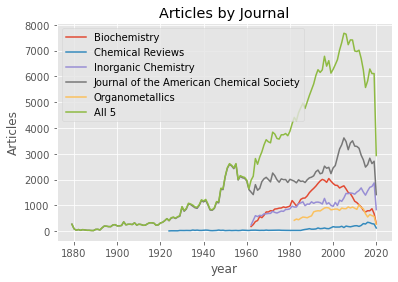

In [3]:
plt.style.use('ggplot')
df.groupby(['journal', 'year']).year.count().unstack('journal').plot()
df.groupby('year').year.count().plot(label='All 5')
plt.ylabel('Articles')
plt.legend()
plt.title('Articles by Journal')

journal_grouped = df.groupby('journal').journal.count()
print(journal_grouped)
print('total:', journal_grouped.sum())

# Cleaning:
Of the more than third of a million articles ever published in these five journals, a number of them are not 'real' scientific articles. Among other article types, these include textbook and software reviews and editorial mastheads.
Looking briefly at the article types in our data, we see that the vast majority are Articles and Communications. If we look more closely at the Articles (and in fact all of these other categories), a substatial number of them are miscategorized by ACS.

In [4]:
print(df.groupby('article_type').article_type.count())

article_type
Accelerated Publication            710
Addition/Correction               2193
Announcement                        11
Article                         314664
Award Paper                         38
Book Review                       2353
Communication                    37051
Computer Software Review            79
Correspondence                      14
Correspondence/Rebuttal              2
Cover Essay                         12
Current Topic                      249
Current Topics/Perspectives        189
Editor's Page                      114
Editorial                          377
Forum Article                      309
From the Bench                      50
New Concept                         17
New Concepts in Biochemistry        73
Note                              2368
Perspective                        383
Rapid Report                       482
Research Article                     1
Retraction                          25
Review                            2756
Review/Persp

The lines of which categories of articles should 'count' as real articles are intrinsically very blurry and dependent on the purpose of the study. For tracing trends in popularity of various research topics, no cleaning is strictly necessary, but we can exclude some obviously unnecessary articles by removing the following article types:
Book Review, Computer Software Review, Announcement, Spotlights, Editor's Page, Roundtable]

Similarly if a given article title is present in more than a small handful of articles, it is unlikely to be a research article. Removing all articles with titles that occur more than three times in the dataset removes (by quick manual inspection) the vast majority of remaining undesired articles while stripping only a single set of desired articles. This quick procedure elimates just over 10,000 articles (<3% of the dataset) and will be more than sufficient for our purposes.

In [5]:
print("Length before cleaning:", len(df))

unwanted_article_types = ['Book Review', 'Computer Software Review', 'Announcement', 'Spotlights', "Editor's Page", 'Roundtable']
uat_mask = df.article_type.apply(lambda x: x in unwanted_article_types)
df_clean = df[~uat_mask]
print("Length after removing article types:", len(df_clean))

unwanted_titles = df_clean.groupby('title').title.count()
unwanted_titles = list(unwanted_titles[unwanted_titles>3].index)
ut_mask = df_clean.title.apply(lambda x: x in unwanted_titles)
df_clean = df_clean[~ut_mask]
print("Length after removing article titles:", len(df_clean))


Length before cleaning: 365299
Length after removing article types: 362307
Length after removing article titles: 354668


# Searching by author:
We can very easily search by author to view papers by a specific author, in this case my graduate school advisor.

In [6]:
dlms_mask = df_clean.authors.apply(lambda x: 'Daniel L. M. Suess' in x)
df_clean[dlms_mask]

,doi,title,authors,journal,year,volume,issue,page_start,page_end,article_type,pub_date,abstract
176686,/doi/10.1021/ja305248f,Dihydrogen Binding to Isostructural S = 1/2 an...,"[Daniel L. M. Suess, Charlene Tsay, Jonas C. P...",Journal of the American Chemical Society,2012,134,34,14158,14164,Article,"August 14, 2012","Two isostructural, nonclassical Co(H2) complex..."
178460,/doi/10.1021/ja400836u,H–H and Si–H Bond Addition to Fe≡NNR2 Intermed...,"[Daniel L. M. Suess, Jonas C. Peters]",Journal of the American Chemical Society,2013,135,13,4938,4941,Communication,"March 11, 2013",The synthesis and characterization of Fe–dipho...
179653,/doi/10.1021/ja406874k,A CO-Derived Iron Dicarbyne That Releases Olef...,"[Daniel L. M. Suess, Jonas C. Peters]",Journal of the American Chemical Society,2013,135,34,12580,12583,Communication,"August 9, 2013",An iron diphosphineborane platform that was pr...
182528,/doi/10.1021/ja507046w,The Cyanide Ligands of [FeFe] Hydrogenase: Pul...,"[William K. Myers, Troy A. Stich, Daniel L. M....",Journal of the American Chemical Society,2014,136,35,12237,12240,Communication,"August 15, 2014",The two cyanide ligands in the assembled clust...
182957,/doi/10.1021/ja508117h,Free H2 Rotation vs Jahn–Teller Constraints in...,"[William A. Gunderson, Daniel L. M. Suess, Hen...",Journal of the American Chemical Society,2014,136,42,14998,15009,Article,"September 22, 2014",Proton exchange within the M–H2 moiety of (TPB...
186082,/doi/10.1021/jacs.5b12512,The Radical SAM Enzyme HydG Requires Cysteine ...,"[Daniel L. M. Suess, Cindy C. Pham, Ingmar Bür...",Journal of the American Chemical Society,2016,138,4,1146,1149,Communication,"January 14, 2016","Three maturase enzymes—HydE, HydF, and HydG—sy..."
189321,/doi/10.1021/jacs.7b01792,Manganese–Cobalt Oxido Cubanes Relevant to Man...,"[Andy I. Nguyen, Daniel L. M. Suess, Lucy E. D...",Journal of the American Chemical Society,2017,139,15,5579,5587,Article,"March 28, 2017",Incorporation of Mn into an established water ...
195704,/doi/10.1021/jacs.9b06975,A Synthetic Model of Enzymatic [Fe4S4]–Alkyl I...,"[Mengshan Ye, Niklas B. Thompson, Alexandra C....",Journal of the American Chemical Society,2019,141,34,13330,13335,Communication,"August 2, 2019",Although alkyl complexes of [Fe4S4] clusters h...
54419,/doi/10.1021/acs.inorgchem.5b00645,Evaluating Molecular Cobalt Complexes for the ...,"[Trevor J. Del Castillo, Niklas B. Thompson, D...",Inorganic Chemistry,2015,54,19,9256,9262,Forum Article,"May 22, 2015",Well-defined molecular catalysts for the reduc...
54800,/doi/10.1021/acs.inorgchem.5b02274,Biosynthesis of the [FeFe] Hydrogenase H Clust...,"[Daniel L. M. Suess, Jon M. Kuchenreuther, Lil...",Inorganic Chemistry,2016,55,2,478,487,Forum Article,"December 24, 2015",Hydrogenase enzymes catalyze the rapid and rev...


# Tracing the trend of iron-sulfur clusters:

We can trace the trending of various chemical topics using regexes to search the titles and abstacts of articles in the dataframe, followed by grouping the articles by year and plotting. I have chosen to look at various terms related to my research.

The five regexes below are a very minimal set of search terms for iron-sulfur clusters and related topics studied by my former group. The first two search for iron-sulfur and -selenium clusters using synthetic and biological notations respectively. The third is for the related cobalt-sulfur and -selenium clusters. The final two are related to perhaps the most well-known biological iron-sulfur cluster--FeMoco is the cluster contained within the nitrogenase protein.

In [7]:
fen_sn = re.compile('Fe[1-9]-?Se?[1-9]') # iron sulfur/selenium clusters
prot_fen_sn = re.compile('[1-9]Fe-?[1-9]Se?') # iron sulfur/selenium clusters (protein notation)
con_sn = re.compile('Co[1-9]-?Se?[1-9]') # cobalt sulfur/selenium clusters
femoco = re.compile('(?i)femoco') # FeMoco
nitrogenase = re.compile('(?i)nitrogenase') # nitrogenase

regexes = [fen_sn, prot_fen_sn, con_sn, femoco, nitrogenase,]

masks = []
for r in regexes:
    mask = df_clean.title.apply(lambda x: bool(r.search(x))) | df_clean.abstract.apply(lambda x: bool(r.search(x)))
    masks.append(mask)
    
masks = np.array(masks).T
mask = masks.any(axis=1)

Text(0.5, 1.0, 'Prevalence of Articles Related to Iron-Sulfur Clusters')

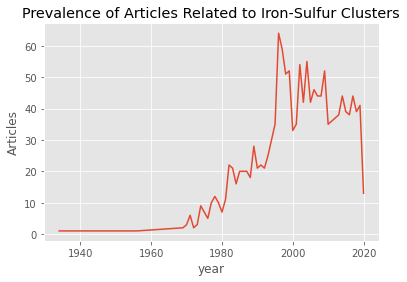

In [8]:
plt.style.use('ggplot')
df_clean[mask].groupby('year').year.count().plot()
plt.ylabel('Articles')
plt.title('Prevalence of Articles Related to Iron-Sulfur Clusters')

Since their discovery ~50 years ago, research on these clusters have steadily increased. As might be expected, the biggest spike occurs around 1996, the year that abstracts became available in the database.

The number of articles per year seems to have levelled off in recent years, mirroring the trend in the articles by journal plot above.